<a href="https://colab.research.google.com/github/lehongminhh2004/NLP/blob/main/NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DỊCH MÁY ANH–PHÁP / VỚI MÔ HÌNH ENCODER–DECODER LSTM


## 1. Cài đặt các thư viện




In [1]:
print("Installing dependencies...")
print("="*80)

!pip -q install spacy

# Cài model FR (như cũ)
!python -m spacy download fr_core_news_sm -q

# Cài model EN: thử download chuẩn, nếu fail thì pip install wheel trực tiếp
try:
    import spacy
    spacy.load("en_core_web_sm")
    print("✓ en_core_web_sm already available")
except Exception:
    try:
        !python -m spacy download en_core_web_sm -q
        print("✓ en_core_web_sm downloaded via spacy")
    except Exception:
        !pip -q install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl
        print("✓ en_core_web_sm installed via direct wheel")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import spacy
import random, math, time
import requests, gzip, io
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Setup completed!")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 58.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✓ en_core_web_sm already available

✅ Setup completed!
🖥️  Device: cuda
🎮 GPU: Tesla T4
💾 Memory: 15.83 GB


## 2. Tải MULTI30K Dataset

In [2]:
print("\n" + "="*80)
print("TẢI MULTI30K (EN–FR)")
print("="*80)

import gzip
import io
import requests

BASE_URL = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"

FILES_GZ = {
    "train.en": "train.en.gz",
    "train.fr": "train.fr.gz",
    "val.en":   "val.en.gz",
    "val.fr":   "val.fr.gz",
    "test.en":  "test_2016_flickr.en.gz",
    "test.fr":  "test_2016_flickr.fr.gz",
}

FILES_PLAIN = {
    "train.en": "train.en",
    "train.fr": "train.fr",
    "val.en":   "val.en",
    "val.fr":   "val.fr",
    "test.en":  "test_2016_flickr.en",
    "test.fr":  "test_2016_flickr.fr",
}

def _download_text(url: str, timeout: int = 60) -> str:
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.text

def _download_gz_lines(url: str, timeout: int = 60) -> list[str]:
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as f:
        return f.read().splitlines()

def download_multi30k():
    data = {}

    print("Downloading .gz files:")
    for key, fname in FILES_GZ.items():
        url = BASE_URL + fname
        try:
            lines = _download_gz_lines(url)
            data[key] = lines
            print(f"  ✓ {fname}: {len(lines)}")
        except Exception as e:
            print(f"  ✗ {fname}: {type(e).__name__}")

    # fallback nếu thiếu file nào đó
    missing = [k for k in FILES_GZ.keys() if k not in data]
    if missing:
        print("\nFallback to plain text for missing files:")
        for key in missing:
            fname = FILES_PLAIN[key]
            url = BASE_URL + fname
            try:
                text = _download_text(url)
                lines = text.splitlines()
                data[key] = lines
                print(f"  ✓ {fname}: {len(lines)}")
            except Exception as e:
                print(f"  ✗ {fname}: {type(e).__name__}")

    # sanity check
    n_train = len(data.get("train.en", []))
    n_val   = len(data.get("val.en", []))
    n_test  = len(data.get("test.en", []))

    print("\n📊 Dataset Statistics:")
    print(f"  • Train: {n_train:,}")
    print(f"  • Val:   {n_val:,}")
    print(f"  • Test:  {n_test:,}")

    if n_train < 1000:
        raise RuntimeError("Dataset seems incomplete (train.en < 1000). Check download URLs/connectivity.")

    # sample
    print("\n📝 Samples:")
    for i in range(min(3, n_train)):
        en = data["train.en"][i]
        fr = data["train.fr"][i]
        print(f"\n[{i+1}] EN: {en[:200] + ('...' if len(en) > 200 else '')}")
        print(f"    FR: {fr[:200] + ('...' if len(fr) > 200 else '')}")

    return data

raw_data = download_multi30k()



TẢI MULTI30K (EN–FR)
  ✓ train.en.gz: 29000
  ✓ train.fr.gz: 29000
  ✓ val.en.gz: 1014
  ✓ val.fr.gz: 1014
  ✓ test_2016_flickr.en.gz: 1000
  ✓ test_2016_flickr.fr.gz: 1000

📊 Dataset Statistics:
  • Train: 29,000
  • Val:   1,014
  • Test:  1,000

📝 Samples:

[1] EN: Two young, White males are outside near many bushes.
    FR: Deux jeunes hommes blancs sont dehors près de buissons.

[2] EN: Several men in hard hats are operating a giant pulley system.
    FR: Plusieurs hommes en casque font fonctionner un système de poulies géant.

[3] EN: A little girl climbing into a wooden playhouse.
    FR: Une petite fille grimpe dans une maisonnette en bois.


## 3. TOKENIZATION VỚI SPACY

In [3]:
print("\n" + "="*80)
print("TOKENIZE với SPACY")
print("="*80)

# yêu cầu: đã có raw_data từ bước tải dataset
import spacy
from tqdm import tqdm

print("Loading spaCy models...")
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")
print("  ✓ en_core_web_sm")
print("  ✓ fr_core_news_sm")

def preprocess_text(text: str) -> str:
    # normalize whitespace + lowercase, giữ dấu câu & accents
    return " ".join(text.split()).lower()

def tokenize_en(text: str) -> list[str]:
    text = preprocess_text(text)
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text: str) -> list[str]:
    text = preprocess_text(text)
    return [tok.text for tok in spacy_fr.tokenizer(text)]

print("\nTokenizing datasets...")
train_en = [tokenize_en(s) for s in tqdm(raw_data["train.en"], desc="Train EN")]
train_fr = [tokenize_fr(s) for s in tqdm(raw_data["train.fr"], desc="Train FR")]
val_en   = [tokenize_en(s) for s in tqdm(raw_data["val.en"],   desc="Val EN")]
val_fr   = [tokenize_fr(s) for s in tqdm(raw_data["val.fr"],   desc="Val FR")]
test_en  = [tokenize_en(s) for s in tqdm(raw_data["test.en"],  desc="Test EN")]
test_fr  = [tokenize_fr(s) for s in tqdm(raw_data["test.fr"],  desc="Test FR")]

print("\n📌 Tokenization example:")
print("EN raw :", raw_data["train.en"][0])
print("EN tok :", train_en[0])
print("FR raw :", raw_data["train.fr"][0])
print("FR tok :", train_fr[0])



TOKENIZE với SPACY
Loading spaCy models...
  ✓ en_core_web_sm
  ✓ fr_core_news_sm

Tokenizing datasets...


Test FR: 100%|██████████| 1000/1000 [00:00<00:00, 22886.18it/s]


📌 Tokenization example:
EN raw : Two young, White males are outside near many bushes.
EN tok : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
FR raw : Deux jeunes hommes blancs sont dehors près de buissons.
FR tok : ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']


## 4. Xây dựng Vocabulary

In [4]:
print("\n" + "="*80)
print("XÂY DỰNG VOCABULARY")
print("="*80)

from collections import Counter

class Vocabulary:
    """
    Vocabulary cho seq2seq:
      - Build từ train set
      - Giữ token có freq >= freq_threshold
      - Giới hạn top_k phổ biến nhất
      - Special tokens: <pad>, <sos>, <eos>, <unk>
    """
    def __init__(self, freq_threshold=2, top_k=10000):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold
        self.top_k = top_k

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            frequencies.update(sentence)

        idx = 4
        for word, count in frequencies.most_common(self.top_k):
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, tokens):
        unk = self.stoi["<unk>"]
        return [self.stoi.get(tok, unk) for tok in tokens]


print("Building vocabularies...")
en_vocab = Vocabulary(freq_threshold=2, top_k=10000)
fr_vocab = Vocabulary(freq_threshold=2, top_k=10000)

en_vocab.build_vocabulary(train_en)
fr_vocab.build_vocabulary(train_fr)

print("\n📊 Vocabulary Statistics:")
print(f"  • English vocab size: {len(en_vocab):,}")
print(f"  • French vocab size:  {len(fr_vocab):,}")

print("\n🏷️  Special Tokens (EN vocab):")
print(f"  • <pad>: {en_vocab.stoi['<pad>']}")
print(f"  • <sos>: {en_vocab.stoi['<sos>']}")
print(f"  • <eos>: {en_vocab.stoi['<eos>']}")
print(f"  • <unk>: {en_vocab.stoi['<unk>']}")

example = train_en[0][:5]
print("\n📝 Numericalization Example:")
print(f"  Tokens:  {example}")
print(f"  Indices: {en_vocab.numericalize(example)}")



XÂY DỰNG VOCABULARY
Building vocabularies...

📊 Vocabulary Statistics:
  • English vocab size: 5,892
  • French vocab size:  6,470

🏷️  Special Tokens (EN vocab):
  • <pad>: 0
  • <sos>: 1
  • <eos>: 2
  • <unk>: 3

📝 Numericalization Example:
  Tokens:  ['two', 'young', ',', 'white', 'males']
  Indices: [16, 24, 15, 25, 774]


## 5. Dataset và Dataloader

In [5]:
print("\n" + "="*80)
print("DATASET & DATALOADER")
print("="*80)

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class TranslationDataset(Dataset):
    """
    Trả về (src_ids, trg_ids) dạng tensor 1D.
    trg_ids có thêm <sos> ở đầu và <eos> ở cuối.
    """
    def __init__(self, src_data, trg_data, src_vocab, trg_vocab):
        self.src_data = src_data
        self.trg_data = trg_data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_tokens = self.src_data[idx]
        trg_tokens = self.trg_data[idx]

        src_ids = self.src_vocab.numericalize(src_tokens)
        trg_ids = (
            [self.trg_vocab.stoi["<sos>"]]
            + self.trg_vocab.numericalize(trg_tokens)
            + [self.trg_vocab.stoi["<eos>"]]
        )

        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(trg_ids, dtype=torch.long)


def collate_fn(batch, pad_idx=0):
    """
    batch: list[(src_1d, trg_1d)]
    return:
      src_batch: [B, src_len]
      src_lengths: [B] (đã sort giảm dần)
      trg_batch: [B, trg_len] (đã sort theo src)
    """
    src_list, trg_list = zip(*batch)

    src_lengths = torch.tensor([len(s) for s in src_list], dtype=torch.long)

    src_batch = pad_sequence(src_list, batch_first=True, padding_value=pad_idx)
    trg_batch = pad_sequence(trg_list, batch_first=True, padding_value=pad_idx)

    src_lengths, sort_idx = src_lengths.sort(descending=True)
    src_batch = src_batch[sort_idx]
    trg_batch = trg_batch[sort_idx]

    return src_batch, src_lengths, trg_batch


BATCH_SIZE = 64

train_dataset = TranslationDataset(train_en, train_fr, en_vocab, fr_vocab)
val_dataset   = TranslationDataset(val_en,   val_fr,   en_vocab, fr_vocab)
test_dataset  = TranslationDataset(test_en,  test_fr,  en_vocab, fr_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("✅ Dataloaders created!")
print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Train batches: {len(train_loader)}")
print(f"  • Val batches:   {len(val_loader)}")
print(f"  • Test batches:  {len(test_loader)}")

src_sample, src_len_sample, trg_sample = next(iter(train_loader))
print("\n📊 Sample shapes:")
print(f"  • src: {src_sample.shape}")
print(f"  • src_lengths: {src_len_sample.shape} (min={src_len_sample.min().item()}, max={src_len_sample.max().item()})")
print(f"  • trg: {trg_sample.shape}")



DATASET & DATALOADER
✅ Dataloaders created!
  • Batch size: 64
  • Train batches: 454
  • Val batches:   16
  • Test batches:  16

📊 Sample shapes:
  • src: torch.Size([64, 29])
  • src_lengths: torch.Size([64]) (min=8, max=29)
  • trg: torch.Size([64, 38])


## 6. Model
### 6.1 Encoder Model

In [6]:
print("\n" + "="*80)
print("ENCODER (LSTM + PACK)")
print("="*80)

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class Encoder(nn.Module):
    """
    LSTM Encoder: nhận src đã padding + src_lengths (đã sort giảm dần),
    dùng pack_padded_sequence để bỏ phần <pad> khi chạy LSTM.
    """
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lengths):
        # src: [B, src_len], src_lengths: [B] (sorted desc)
        embedded = self.dropout(self.embedding(src))  # [B, src_len, emb_dim]

        packed = pack_padded_sequence(
            embedded,
            lengths=src_lengths.cpu(),
            batch_first=True,
            enforce_sorted=True
        )

        _, (hidden, cell) = self.lstm(packed)
        return hidden, cell

print("✅ Encoder class defined!")



ENCODER (LSTM + PACK)
✅ Encoder class defined!


### 6.2 Decoder Model

In [46]:
print("\n" + "="*80)
print(" DECODER")
print("="*80)

import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, teacher_forcing_ratio=0.5):
        input = input.unsqueeze(1)  # [B] -> [B, 1]
        embedded = self.dropout(self.embedding(input))  # [B, 1, emb_dim]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # output: [B, 1, hidden_dim]
        prediction = self.fc_out(output.squeeze(1))  # [B, output_dim]

        # Teacher Forcing: chọn token tiếp theo dựa trên ground truth hoặc predicted token
        teacher_force = random.random() < teacher_forcing_ratio
        top1 = prediction.argmax(1)  # [B]
        input = trg[:, t] if teacher_force else top1

        return prediction, hidden, cell


print("✅ Decoder class defined!")



 DECODER
✅ Decoder class defined!


### 6.3 Seq2Seq Model

In [8]:
print("\n" + "="*80)
print("KẾT HỢP ENCODER-DECODER")
print("="*80)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size, device=self.device)

        hidden, cell = self.encoder(src, src_lengths)

        inp = trg[:, 0]
        for t in range(1, trg_len):
            out, hidden, cell = self.decoder(inp, hidden, cell)
            outputs[:, t, :] = out

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = out.argmax(1)
            inp = trg[:, t] if teacher_force else top1

        return outputs

# --------------------------
# Hyperparameters + init
# --------------------------
INPUT_DIM  = len(en_vocab)
OUTPUT_DIM = len(fr_vocab)

EMBEDDING_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.3
TEACHER_FORCING_RATIO = 0.5

encoder = Encoder(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("✅ Seq2Seq model initialized!")
print(f"  • Total parameters: {count_parameters(model):,}")
print(f"  • Encoder params:   {count_parameters(encoder):,}")
print(f"  • Decoder params:   {count_parameters(decoder):,}")

print(f"\n⚙️  Hyperparameters:")
print(f"  • Hidden size:         {HIDDEN_DIM}")
print(f"  • Embedding dim:       {EMBEDDING_DIM}")
print(f"  • LSTM layers:         {N_LAYERS}")
print(f"  • Dropout:             {DROPOUT}")
print(f"  • Teacher forcing:     {TEACHER_FORCING_RATIO}")



KẾT HỢP ENCODER-DECODER
✅ Seq2Seq model initialized!
  • Total parameters: 13,840,198
  • Encoder params:   5,186,560
  • Decoder params:   8,653,638

⚙️  Hyperparameters:
  • Hidden size:         512
  • Embedding dim:       256
  • LSTM layers:         2
  • Dropout:             0.3
  • Teacher forcing:     0.5


## 7. Training Function

In [47]:
print("\n" + "="*80)
print("ĐỊNH NGHĨA TRAINING")
print("="*80)

# NOTE: iterator phải yield (src, src_lengths, trg) từ collate_fn

def train_epoch(model, iterator, optimizer, criterion, clip, device, tf_ratio):
    model.train()
    epoch_loss = 0.0

    for src, src_lengths, trg in tqdm(iterator, desc="Training", leave=False):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, src_lengths, trg, teacher_forcing_ratio=tf_ratio)  # [B, T, V]
        V = output.size(-1)

        output = output[:, 1:, :].reshape(-1, V)  # bỏ <sos>
        trg    = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


@torch.no_grad()
def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0.0

    for src, src_lengths, trg in tqdm(iterator, desc="Evaluating", leave=False):
        src, trg = src.to(device), trg.to(device)

        output = model(src, src_lengths, trg, teacher_forcing_ratio=0)  # no TF
        V = output.size(-1)

        output = output[:, 1:, :].reshape(-1, V)
        trg    = trg[:, 1:].reshape(-1)

        epoch_loss += criterion(output, trg).item()

    return epoch_loss / len(iterator)


# ---------------------------
# Loss / Optimizer / Scheduler
# ---------------------------
PAD_IDX = fr_vocab.stoi["<pad>"]                 # ignore PAD của target (FR)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

CLIP = 1.0

print("✅ Training functions ready!")
print("\n⚙️  Training Configuration:")
print(f"  • Loss:         CrossEntropyLoss(ignore_index={PAD_IDX})")
print("  • Optimizer:    Adam(lr=1e-3)")
print("  • Scheduler:    ReduceLROnPlateau(factor=0.5, patience=2)")
print(f"  • Gradient clip: {CLIP}")
print(f"  • Teacher forcing ratio (train): {TEACHER_FORCING_RATIO}")



ĐỊNH NGHĨA TRAINING
✅ Training functions ready!

⚙️  Training Configuration:
  • Loss:         CrossEntropyLoss(ignore_index=0)
  • Optimizer:    Adam(lr=1e-3)
  • Scheduler:    ReduceLROnPlateau(factor=0.5, patience=2)
  • Gradient clip: 1.0
  • Teacher forcing ratio (train): 0.5


## 8. Training

In [48]:
print("\n" + "="*80)
print("TRAINING")
print("="*80)

N_EPOCHS = 20
PATIENCE = 3
best_valid_loss = float("inf")
patience_counter = 0

train_losses, val_losses = [], []

print(f"\n⏰ Training {N_EPOCHS} epochs...")
print(f"📊 Early stopping patience: {PATIENCE}")
print(f"🎛️  Teacher forcing (train): {TEACHER_FORCING_RATIO}")
print("="*80)

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # IMPORTANT: train_epoch hiện cần tf_ratio
    train_loss = train_epoch(
        model, train_loader, optimizer, criterion,
        clip=CLIP, device=device, tf_ratio=TEACHER_FORCING_RATIO
    )

    valid_loss = evaluate(model, val_loader, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    scheduler.step(valid_loss)

    print(f"\n📅 Epoch: {epoch+1:02}/{N_EPOCHS} | ⏱️  Time: {int(epoch_mins)}m {int(epoch_secs)}s")
    print(f"   📉 Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}")
    print(f"   📉 Val Loss:   {valid_loss:.3f} | PPL: {math.exp(valid_loss):7.3f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("   ✅ Best model saved!")
    else:
        patience_counter += 1
        print(f"   ⏳ Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\n⚠️  Early stopping at epoch {epoch+1}")
        break

print("\n" + "="*80)
print("✅ Training completed!")



TRAINING

⏰ Training 20 epochs...
📊 Early stopping patience: 3
🎛️  Teacher forcing (train): 0.5



📅 Epoch: 01/20 | ⏱️  Time: 0m 41s
   📉 Train Loss: 1.616 | PPL:   5.033
   📉 Val Loss:   3.259 | PPL:  26.034
   ✅ Best model saved!



📅 Epoch: 02/20 | ⏱️  Time: 0m 39s
   📉 Train Loss: 1.497 | PPL:   4.469
   📉 Val Loss:   3.270 | PPL:  26.319
   ⏳ Patience: 1/3



📅 Epoch: 03/20 | ⏱️  Time: 0m 40s
   📉 Train Loss: 1.430 | PPL:   4.177
   📉 Val Loss:   3.352 | PPL:  28.556
   ⏳ Patience: 2/3



📅 Epoch: 04/20 | ⏱️  Time: 0m 39s
   📉 Train Loss: 1.368 | PPL:   3.928
   📉 Val Loss:   3.325 | PPL:  27.790
   ⏳ Patience: 3/3

⚠️  Early stopping at epoch 4

✅ Training completed!


## 9. Vẽ đường training


TÓM TẮT BEST EPOCH (THEO VAL LOSS)
✅ Best epoch: 1/4
  • Train Loss: 1.616 | Train PPL: 5.033
  • Val   Loss: 3.259 | Val   PPL: 26.034

📊 BƯỚC 9.2: VẼ THÊM ĐIỂM BEST EPOCH TRÊN BIỂU ĐỒ


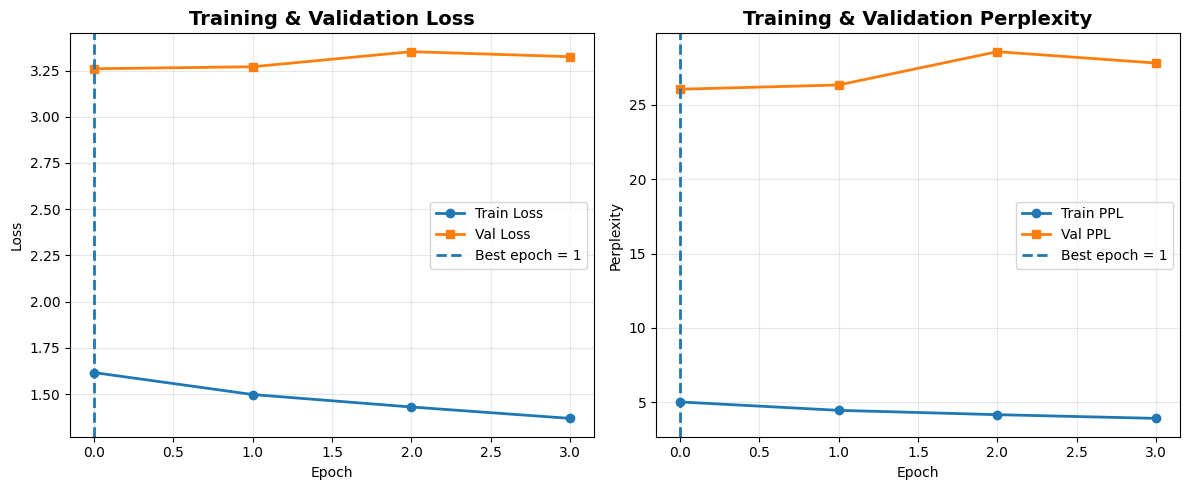

✅ Saved: training_curves_best_epoch.png


In [49]:
print("\n" + "="*80)
print("TÓM TẮT BEST EPOCH (THEO VAL LOSS)")
print("="*80)

# train_losses, val_losses đã có từ bước 8
best_epoch = int(np.argmin(val_losses)) + 1
best_train_loss = train_losses[best_epoch - 1]
best_val_loss = val_losses[best_epoch - 1]

print(f"✅ Best epoch: {best_epoch}/{len(val_losses)}")
print(f"  • Train Loss: {best_train_loss:.3f} | Train PPL: {math.exp(best_train_loss):.3f}")
print(f"  • Val   Loss: {best_val_loss:.3f} | Val   PPL: {math.exp(best_val_loss):.3f}")

print("\n" + "="*80)
print("📊 BƯỚC 9.2: VẼ THÊM ĐIỂM BEST EPOCH TRÊN BIỂU ĐỒ")
print("="*80)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker="o", linewidth=2)
plt.plot(val_losses,   label="Val Loss",   marker="s", linewidth=2)
plt.axvline(best_epoch - 1, linestyle="--", linewidth=2, label=f"Best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)

# PPL
plt.subplot(1, 2, 2)
train_ppl = [math.exp(x) for x in train_losses]
val_ppl   = [math.exp(x) for x in val_losses]
plt.plot(train_ppl, label="Train PPL", marker="o", linewidth=2)
plt.plot(val_ppl,   label="Val PPL",   marker="s", linewidth=2)
plt.axvline(best_epoch - 1, linestyle="--", linewidth=2, label=f"Best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Training & Validation Perplexity", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves_best_epoch.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved: training_curves_best_epoch.png")


## 10. Đánh giá mô hình trên tập Test

In [12]:
print("\n" + "="*80)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*80)

# ---------------------------
# 1️⃣ Load lại mô hình tốt nhất
# ---------------------------
# Ở bước training (Bước 8), mỗi khi val_loss tốt hơn,
# ta đã lưu trọng số mô hình vào file 'best_model.pth'.
# Tại đây, ta load lại trọng số đó để đánh giá trên test set.
checkpoint_path = "best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

print(f"✅ Loaded best model from: {checkpoint_path}")
# ---------------------------
# 2️⃣ Đánh giá trên tập test
# ---------------------------
# Sử dụng lại hàm evaluate đã định nghĩa ở Bước 7.
#   - Không dùng teacher forcing (ratio=0)
#   - Không tính gradient (trong hàm evaluate đã có torch.no_grad())
test_loss = evaluate(model, test_loader, criterion, device)

# ---------------------------
# 3️⃣ In kết quả
# ---------------------------
print(f"\n🎯 Test Results:")
print(f"  • Test Loss: {test_loss:.3f}")
print(f"  • Test PPL:  {math.exp(test_loss):.3f}")
#   - Test Loss: cross-entropy trung bình trên toàn bộ tập test
#   - Test PPL (Perplexity): e^(loss), thước đo mức độ "bối rối" của mô hình
#       + PPL càng thấp → mô hình càng dự đoán tốt chuỗi token trên test set



ĐÁNH GIÁ TRÊN TEST SET
✅ Loaded best model from: best_model.pth



🎯 Test Results:
  • Test Loss: 3.184
  • Test PPL:  24.140


## 11. Hàm dịch

In [13]:
print("\n" + "="*80)
print("INFERENCE - HÀM DỊCH")
print("="*80)

def translate_sentence(model, sentence, src_vocab, trg_vocab, device, max_len=50):
    model.eval()

    # 1) tokenize
    tokens = tokenize_en(sentence) if isinstance(sentence, str) else sentence

    # 2) numericalize
    src_ids = src_vocab.numericalize(tokens)
    if len(src_ids) == 0:
        return []

    src_tensor  = torch.LongTensor(src_ids).unsqueeze(0).to(device)   # [1, src_len]
    src_lengths = torch.LongTensor([len(src_ids)]).to(device)         # [1]

    trg_indexes = [trg_vocab.stoi["<sos>"]]

    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor, src_lengths)

        for _ in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)  # [1]
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            pred_token = output.argmax(1).item()
            trg_indexes.append(pred_token)

            if pred_token == trg_vocab.stoi["<eos>"]:
                break

    # id -> token, bỏ <sos>, <eos>
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:-1]

@torch.no_grad()
def translate(sentence: str, max_len: int = 50) -> str:
    return " ".join(translate_sentence(model, sentence, en_vocab, fr_vocab, device, max_len=max_len))

print("✅ Translation functions defined!")

print("\n🌐 Example Translations:")
print("="*80)

examples = [
    "a man in a blue shirt is standing on a ladder cleaning a window .",
    "a little girl climbing into a wooden playhouse .",
    "a dog running through the grass .",
    "two young guys with shaggy hair look at their hands while hanging out in the yard .",
    "a child in a pink dress is climbing up a set of stairs in an entry way ."
]

for i, sent in enumerate(examples, 1):
    print(f"\n{i}. 🇬🇧 EN: {sent}")
    print(f"   🇫🇷 FR: {translate(sent)}")



INFERENCE - HÀM DỊCH
✅ Translation functions defined!

🌐 Example Translations:

1. 🇬🇧 EN: a man in a blue shirt is standing on a ladder cleaning a window .
   🇫🇷 FR: un homme en t - shirt bleu est debout sur une échelle près d' une fenêtre .

2. 🇬🇧 EN: a little girl climbing into a wooden playhouse .
   🇫🇷 FR: une petite fille grimpe dans une maisonnette en bois .

3. 🇬🇧 EN: a dog running through the grass .
   🇫🇷 FR: un chien courant dans l' herbe .

4. 🇬🇧 EN: two young guys with shaggy hair look at their hands while hanging out in the yard .
   🇫🇷 FR: deux jeunes gars avec des cheveux gris regardent leurs mains dans leurs mains dans leurs mains .

5. 🇬🇧 EN: a child in a pink dress is climbing up a set of stairs in an entry way .
   🇫🇷 FR: un enfant en robe rose fait un escalier devant un parking .


## 12. Tính BLEU SCORE

In [14]:
print("\n" + "="*80)
print("TÍNH BLEU SCORE")
print("="*80)

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

def calculate_bleu(data, src_vocab, trg_vocab, model, device, max_samples=None):
    if max_samples is not None:
        data = data[:max_samples]

    targets, outputs = [], []
    print(f"\n🔄 Translating {len(data)} sentences...")

    for src, trg in tqdm(data, desc="Translating"):
        pred_trg = translate_sentence(model, src, src_vocab, trg_vocab, device)
        targets.append([trg])     # corpus_bleu expects list-of-references
        outputs.append(pred_trg)  # hypothesis

    print("📊 Calculating BLEU scores (NLTK corpus_bleu)...")
    smooth = SmoothingFunction().method4
    avg_bleu = corpus_bleu(targets, outputs, smoothing_function=smooth) * 100

    return avg_bleu, outputs, targets


print("\n" + "="*80)
print("🎯 EVALUATING ON TEST SET")
print("="*80)

test_data = list(zip(test_en, test_fr))
bleu_score, predictions, references = calculate_bleu(
    test_data, en_vocab, fr_vocab, model, device, max_samples=500
)

print(f"\n🎯 BLEU Score: {bleu_score:.2f}")

print(f"\n📊 Translation Statistics:")
print(f"  • Number of sentences: {len(predictions)}")
print(f"  • Average BLEU: {bleu_score:.2f}")

print(f"\n📏 BLEU by Sentence Length:")
short_bleu, medium_bleu, long_bleu = [], [], []

smooth = SmoothingFunction().method4
test_data_used = test_data[:len(predictions)]

# DEBUG = False  # bật nếu cần
# if DEBUG:
#     print(f"DEBUG lens: test_data_used={len(test_data_used)}, preds={len(predictions)}, refs={len(references)}")

for (src_tokens, _), pred, ref in zip(test_data_used, predictions, references):
    src_len = len(src_tokens)
    bleu = sentence_bleu(ref, pred, smoothing_function=smooth) * 100

    if src_len < 10:
        short_bleu.append(bleu)
    elif src_len <= 20:
        medium_bleu.append(bleu)
    else:
        long_bleu.append(bleu)

if short_bleu:
    print(f"  • Short (<10 words):   {sum(short_bleu)/len(short_bleu):.2f} ({len(short_bleu)} sentences)")
if medium_bleu:
    print(f"  • Medium (10-20):      {sum(medium_bleu)/len(medium_bleu):.2f} ({len(medium_bleu)} sentences)")
if long_bleu:
    print(f"  • Long (>20 words):    {sum(long_bleu)/len(long_bleu):.2f} ({len(long_bleu)} sentences)")



TÍNH BLEU SCORE

🎯 EVALUATING ON TEST SET

🔄 Translating 500 sentences...


Translating: 100%|██████████| 500/500 [00:03<00:00, 125.26it/s]


📊 Calculating BLEU scores (NLTK corpus_bleu)...

🎯 BLEU Score: 35.99

📊 Translation Statistics:
  • Number of sentences: 500
  • Average BLEU: 35.99

📏 BLEU by Sentence Length:
  • Short (<10 words):   43.30 (103 sentences)
  • Medium (10-20):      33.68 (384 sentences)
  • Long (>20 words):    17.62 (13 sentences)


## 13. SHOW EXAMPLE TRANSLATIONS

In [15]:
print("\n" + "="*80)
print("🌐 EXAMPLE TRANSLATIONS")
print("="*80)

# Lưu ý:
#   - Đến bước này, bạn đã có:
#       + test_en      : danh sách câu nguồn (English), mỗi câu là list token
#       + references   : list các reference câu đích (French), dạng [[token1, token2, ...]]
#       + predictions  : list các câu dịch do mô hình sinh ra (list token)
#   - Đảm bảo đã import random: import random

# Chọn ngẫu nhiên một số ví dụ để xem chất lượng dịch
#   - random.sample: lấy ngẫu nhiên k phần tử không trùng từ range(len(predictions))
#   - min(10, len(predictions)): nếu câu ít hơn 10 thì chỉ lấy bấy nhiêu
sample_indices = random.sample(range(len(predictions)), min(10, len(predictions)))

# Duyệt qua từng index được chọn
for idx in sample_indices:
    # Câu nguồn tiếng Anh (list token)
    src_sent = test_en[idx]
    # Câu tham chiếu tiếng Pháp (list token), references[idx] là [ref_tokens]
    ref_sent = references[idx][0]
    # Câu mô hình dịch ra (list token)
    pred_sent = predictions[idx]

    print(f"\n{'─'*80}")
    # Ghép list token thành chuỗi text bằng ' '.join(...)
    print(f"🇬🇧 Source:    {' '.join(src_sent)}")
    print(f"🇫🇷 Reference: {' '.join(ref_sent)}")
    print(f"🤖 Predicted:  {' '.join(pred_sent)}")

    # Tính "word accuracy" đơn giản:
    #   - So sánh từng cặp từ (pred, ref) tại cùng vị trí
    #   - Đếm số từ trùng khớp
    correct_words = sum(1 for p, r in zip(pred_sent, ref_sent) if p == r)
    # Chia cho độ dài câu tham chiếu để ra % (tránh chia cho 0)
    accuracy = correct_words / max(len(ref_sent), 1) * 100

    # Chênh lệch độ dài giữa câu dự đoán và câu tham chiếu
    len_diff = len(pred_sent) - len(ref_sent)

    print(f"📊 Word Accuracy: {accuracy:.1f}% | Length: {len(pred_sent)} vs {len(ref_sent)} ({len_diff:+d})")

print("\n" + "="*80)



🌐 EXAMPLE TRANSLATIONS

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    a young boy wearing white pants is jumping off the couch .
🇫🇷 Reference: un jeune garçon vêtu d' un pantalon blanc saute sur le canapé .
🤖 Predicted:  un jeune garçon vêtu d' un pantalon blanc saute par - dessus son canapé .
📊 Word Accuracy: 69.2% | Length: 15 vs 13 (+2)

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    a child wearing a yellow shirt is jumping up and down .
🇫🇷 Reference: un enfant en maillot jaune saute .
🤖 Predicted:  un enfant vêtu d' un t - shirt jaune saute par - dessus .
📊 Word Accuracy: 28.6% | Length: 14 vs 7 (+7)

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    the dali lama during a reception where participants have brought carnations , parasols and prayer flags .
🇫🇷 Reference: le dalaï lama lors d' une réception où les participants ont apporté des œ

## Định Nghĩa Lớp Attention

In [41]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)  # Tính trọng số attention
        self.v = nn.Parameter(torch.randn(hidden_dim))  # Trọng số v, khởi tạo từ phân phối chuẩn

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.squeeze(0)  # [batch_size, hidden_dim]
        encoder_outputs = encoder_outputs  # [batch_size, src_len, hidden_dim]

        # Tính điểm attention
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=1)))  # [batch_size, src_len, hidden_dim]

        # Chuyển đổi self.v thành tensor có kích thước [1, hidden_dim] để phép toán nhân ma trận khớp
        energy = energy.matmul(self.v.unsqueeze(0))  # [batch_size, src_len], thêm chiều cho v: [1, hidden_dim]

        return torch.nn.functional.softmax(energy, dim=1).unsqueeze(1)  # Trả về trọng số attention: [batch_size, 1, src_len]


## Định Nghĩa Decoder Với Attention

In [43]:
class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)  # Hidden state + Context vector
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hidden_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)  # [B, 1]
        embedded = self.dropout(self.embedding(input))  # [B, 1, emb_dim]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # [B, 1, hidden_dim]

        # Áp dụng Attention
        attention_weights = self.attention(hidden, encoder_outputs)  # [B, 1, src_len]
        context = attention_weights.bmm(encoder_outputs)  # [B, 1, hidden_dim]

        # Kết hợp hidden state với context vector
        output = torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)  # [B, hidden_dim * 2]
        prediction = self.fc_out(output)  # [B, output_dim]

        return prediction, hidden, cell


## Định Nghĩa Mô Hình Seq2Seq Với Attention

In [44]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size, device=self.device)

        # Lấy hidden và cell state từ encoder
        hidden, cell = self.encoder(src, src_lengths)

        # Sử dụng tất cả các encoder outputs, không chỉ hidden state cuối cùng
        encoder_outputs = hidden[0]  # [batch_size, src_len, hidden_dim]

        inp = trg[:, 0]  # Sử dụng <sos> token làm input ban đầu
        for t in range(1, trg_len):
            # Pass input qua decoder
            out, hidden, cell = self.decoder(inp, hidden, cell, encoder_outputs)
            outputs[:, t, :] = out

            # Quyết định có sử dụng teacher forcing hay không
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = out.argmax(1)
            inp = trg[:, t] if teacher_force else top1

        return outputs


## Huấn Luyện Mô Hình Với Attention

In [45]:
# Đảm bảo mô hình và dữ liệu đều trên cùng một device (GPU hoặc CPU)
attention_model = attention_model.to(device)

train_losses, val_losses = [], []
for epoch in range(N_EPOCHS):
    start_time = time.time()

    # Đảm bảo dữ liệu trong train_loader được chuyển sang đúng device
    train_loss = train_epoch(
        attention_model, train_loader, optimizer, criterion, clip=CLIP, device=device, tf_ratio=TEACHER_FORCING_RATIO
    )

    valid_loss = evaluate(attention_model, val_loader, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    # Điều chỉnh learning rate sau mỗi epoch
    scheduler.step(valid_loss)

    print(f"\n📅 Epoch: {epoch+1:02}/{N_EPOCHS} | ⏱️ Time: {int(epoch_mins)}m {int(epoch_secs)}s")
    print(f"   📉 Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}")
    print(f"   📉 Val Loss:   {valid_loss:.3f} | PPL: {math.exp(valid_loss):7.3f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save(attention_model.state_dict(), "best_attention_model.pth")
        print("   ✅ Best model saved!")
    else:
        patience_counter += 1
        print(f"   ⏳ Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

    # In learning rate hiện tại
    print(f"   🎛 Current learning rate: {optimizer.param_groups[0]['lr']:.6f}")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2 but got size 19 for tensor number 1 in the list.

## Dịch Thành Quả Của Mô Hình Với Attention

## So Sánh BLEU Score Giữa Hai Mô Hình